In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


## Loading the data:



Metdata Lifeline cluster:
/groups/umcg-lifelines/prm02/projects/ov22_0666/dataset_order_202403/
-> Need to be copy to our own local directory for processing!
We copied all the files into our group directory:
/groups/umcg-lifelines/tmp01/projects/ov22_0666/metadata_copy/dataset_order_202403/dataset_order_202403

Blood Metabolome omic:
/groups/umcg-lifelines/rsc01/releases/deep_nmr_data/v1/data/LLD_bloodlipids_nmr.txt.gz

Data directory: 
/groups/umcg-lifelines/prm03/releases

We proccessed DEEP data ourown (Tal), files are in the cluster under:
/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/data/feature_tables

Linkage file to connect metadata sample id with microbiome sample ids:

/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/OV22_00666_deep_linkage_file-v2.csv”

In [2]:
# Mapping different pids:
linkage_mgs = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/data/linkage_file_MGS.txt", header=None, sep=" ")
linkage_mgs.columns = ['LLDEEP_ID', 'sample_alias']
linkage_mgs['sample_alias'] = linkage_mgs['sample_alias'].str.replace('LL', '', regex=False)

linkage_ega = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/data/feature_tables/EGA-metadata/sample_file.tsv", sep="\t")
linkage_ega['sample_alias'] = linkage_ega['sample_alias'].str.replace('LL', '', regex=False)

pids_mapping = pd.merge(linkage_mgs, linkage_ega, on="sample_alias", how="inner")

### Load microbiome data:

In [3]:
taxonomy_deep_path = '/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/data/feature_tables/kraken_species_level_taxonomy.tsv'
taxonomy_deep = pd.read_csv(taxonomy_deep_path, sep='\t')

taxonomy_deep = taxonomy_deep.drop(columns=['9002000001328080LL'])

taxonomy_deep = taxonomy_deep.set_index('Taxon').T

taxonomy_deep = taxonomy_deep.reset_index(names='sample')

taxonomy_deep = pd.merge(pids_mapping[["LLDEEP_ID", "file_accession_id"]], taxonomy_deep, 
                         left_on = "file_accession_id", right_on="sample", how="inner").drop(
    columns=['file_accession_id', 'sample']).set_index('LLDEEP_ID')


In [4]:
taxonomy_deep.head()

,JADJOV01 sp016713585,Odoribacter sp905193145,Deinococcus sp000745175,Evtepia sp004551945,Corynebacterium durum,An92 sp009935845,Stercoripulliclostridium_A merdigallinarum,F23-B02 sp900556535,UBA7185 sp900556545,Oxalobacter sp905202055,...,Vibrio sp001874155,Streptosporangium roseum,Bog-1183 sp003136635,Novosphingobium lentum,SOJA01 sp014859805,Bacillus_A cereus,Mycobacterium sp903884065,BMS3BBIN02 sp013151445,Prochlorococcus_A sp003212755,GRL18 sp016097415
LLDEEP_ID,,,,,,,,,,,,,,,,,,,,,
LLDeep_0001,0,71,0,37,108,56,14,638,163,0,...,0,0,0,0,0,0,0,0,0,0
LLDeep_0002,29,0,0,0,1203,0,10,0,59,13,...,0,0,0,0,0,0,0,0,0,0
LLDeep_0006,0,189,0,725,291,79,34,49,30,31,...,0,0,0,0,0,0,0,0,0,0
LLDeep_0007,0,520,0,22,214,18,18,63,37,0,...,0,0,0,0,0,0,0,0,0,0
LLDeep_0010,0,318,0,33233,604,75,15,102,67,15,...,0,0,0,0,0,0,0,0,0,0


In [5]:
taxonomy_deep.shape

(1097, 52648)

### Rarefy: 

100%|█████████████████████████████████████████████████████████████████| 10/10 [05:21<00:00, 32.13s/it]


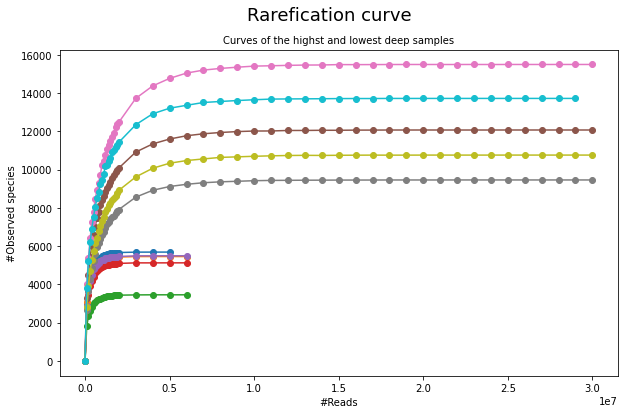

In [18]:
# Rarefication curve: Number of observed species vs. number of reads
if not os.path.exists('preprocessed_data/rarefied_kraken_species_level_taxonomy.pkl'): 
    random_seed = 0 
    np.random.seed(random_seed)
    samples_ = list(taxonomy_deep.sum(axis=1).nsmallest(n=5).index) + list(taxonomy_deep.sum(axis=1).nlargest(n=5).index)
    fig, ax = plt.subplots(figsize=(10,6))

    for i,sample in enumerate(tqdm(samples_)):
        read_number_to_observed_species = {}
        p = taxonomy_deep.loc[sample, :] / taxonomy_deep.loc[sample, :].sum()
        read_numbers_list = list(range(0, 2000000, 100000)) + list(range(2000000, taxonomy_deep.loc[sample, :].sum(), 1000000))
        for read_num in read_numbers_list:
            subsample_index = np.random.choice(a=taxonomy_deep.columns.shape[0], size=read_num, p=p)
            # To really create the subsample sample we can: 

            # subsample = pd.Series(subsample_index).map(pd.Series(taxonomy_deep.columns))
            # subsample.groupby(subsample).apply(lambda x: x.shape[0]).reindex(taxonomy_deep.columns).fillna(0)

            # But for Rarefication curve it's enough to compute the number of unique species:
            num_observed_species = pd.Series(subsample_index).unique().shape[0]
            read_number_to_observed_species[read_num] = num_observed_species
        ax.plot(list(read_number_to_observed_species.keys()), list(read_number_to_observed_species.values()), '-o')
    ax.set_xlabel('#Reads')
    ax.set_ylabel('#Observed species')
    plt.suptitle('Rarefication curve', fontsize=18)
    plt.title('Curves of the highst and lowest deep samples', fontsize=10)
    plt.show()

We can see that subsampling according to the smallest sample read number doesn't impact strongly the number of observed species in the samples, cause we get to saturation before (the samples are sequance deep anyhow). 
So we will Rarefied according to the smallest read number, to not loss any sample:

In [20]:
# Rarefied according to the smallest sample read:
if not os.path.exists('preprocessed_data/rarefied_kraken_species_level_taxonomy.pkl'): 
    reads_number = taxonomy_deep.sum(axis=1).min()
    random_seed = 0 
    np.random.seed(random_seed)

    # Normalize the entire DataFrame and sample indices for all samples
    taxonomy_deep_normalized = taxonomy_deep.div(taxonomy_deep.sum(axis=1), axis=0)

    # Prepare to collect subsamples
    rarefied_samples = []

    # Sample from each row in the normalized DataFrame
    for sample_name in tqdm(taxonomy_deep_normalized.index):
        probabilities = taxonomy_deep_normalized.loc[sample_name]
        sampled_indices = np.random.choice(taxonomy_deep.columns, size=reads_number, p=probabilities)

        # Count occurrences of each column name
        subsample_counts = pd.Series(sampled_indices).value_counts().reindex(taxonomy_deep.columns, fill_value=0)

        # Store the result in a DataFrame for each sample
        rarefied_samples.append(subsample_counts.rename(sample_name))

    # Combine all subsamples into a DataFrame
    rarefied_samples = pd.DataFrame(rarefied_samples)
    rarefied_samples.to_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy.pkl')
    taxonomy_deep = rarefied_samples
else:
    taxonomy_deep = pd.read_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy.pkl')

100%|█████████████████████████████████████████████████████████████| 1097/1097 [21:55<00:00,  1.20s/it]


In [6]:
taxonomy_deep = pd.read_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy.pkl')

### Filter rare species and compute relative abundance: 

In [7]:
# Calculate RA:
taxonomy_deep = taxonomy_deep.divide(taxonomy_deep.sum(axis=1), axis=0)

In [8]:
RA_THRESHOLD = 0.0001
print(f"Species that have at least one sample with relative abundance above {RA_THRESHOLD}: {np.count_nonzero((taxonomy_deep > RA_THRESHOLD).any(axis=0))}")
print(f"out of {taxonomy_deep.shape[1]} species, aka {round((np.count_nonzero((taxonomy_deep > RA_THRESHOLD).any(axis=0)) / taxonomy_deep.shape[1]) * 100, 2)}%")

Species that have at least one sample with relative abundance above 0.0001: 4938
out of 52648 species, aka 9.38%


In [9]:
# Filter:
PERCENTAGE_OF_SAMPLES = 10
RA_THRESHOLD = 0.001

min_number_of_samples = int((taxonomy_deep.shape[0] / 100) * PERCENTAGE_OF_SAMPLES)
non_rare_columns = taxonomy_deep.columns[
    ((taxonomy_deep > RA_THRESHOLD).sum(axis=0)) >= min_number_of_samples]
len(non_rare_columns)
print("Species that at least 10 % of the samples have relative abundance above the threshold:")
print(f"{len(non_rare_columns)} out of {taxonomy_deep.shape[1]} species, aka {round((len(non_rare_columns) / taxonomy_deep.shape[1]) * 100, 2)}%")
taxonomy_deep = taxonomy_deep[non_rare_columns]

Species that at least 10 % of the samples have relative abundance above the threshold:
305 out of 52648 species, aka 0.58%


In [10]:
taxonomy_deep.head()

,Ruminiclostridium_E siraeum,CAG-1427 sp000435675,Blautia_A faecis,Tidjanibacter inops_A,Gemmiger qucibialis,Collinsella sp900556515,UMGS1375 sp900066615,Bacteroides intestinigallinarum,Acetatifactor intestinalis,Butyribacter sp003529475,...,Eubacterium_F sp900539115,Blautia_A sp900548245,Ruminococcus_E sp905215855,Agathobacter rectalis,Prevotella sp003447235,Prevotella sp900546535,Prevotella hominis,Prevotella sp900556795,Cryptobacteroides sp000433355,Limisoma sp000437795
LLDeep_0001,0.033714,0.000096,0.006661,0.000004,0.011214,0.000414,0.003390,0.000088,0.001437,0.000101,...,0.002054,0.002066,0.000705,0.028471,0.000004,0.000488,0.000274,0.000191,0.000042,0.000005
LLDeep_0002,0.000001,0.000004,0.006736,0.000000,0.000089,0.000457,0.002402,0.000021,0.000039,0.000138,...,0.000021,0.009857,0.002577,0.011405,0.000173,0.000024,0.000025,0.000000,0.000000,0.000000
LLDeep_0006,0.000469,0.000931,0.004121,0.000005,0.012228,0.000660,0.000143,0.000400,0.000292,0.000056,...,0.000112,0.000355,0.010287,0.058814,0.000003,0.001693,0.000354,0.000461,0.000004,0.000012
LLDeep_0007,0.001531,0.000011,0.009939,0.001206,0.013773,0.001261,0.001434,0.000490,0.000080,0.000464,...,0.000230,0.013588,0.003521,0.013920,0.000110,0.028257,0.007233,0.026496,0.000009,0.000006
LLDeep_0010,0.000005,0.000000,0.081322,0.000004,0.000043,0.000194,0.000103,0.000784,0.000030,0.000071,...,0.000015,0.000371,0.001683,0.000063,0.000002,0.000002,0.000003,0.000009,0.000000,0.000000


In [11]:
taxonomy_deep.shape

(1097, 305)

In [12]:
taxonomy_deep.to_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy_filtered_ra.pkl')

### Load metadata - Blood tests:

In [5]:
deep_link = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/OV22_00666_deep_linkage_file-v2.csv")
a1v2 = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/1a_v_2_results_filtered_to_deep.csv")
vo = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/variable_overview.csv")
blood_vo = vo[(vo["subsection"] == "Biospecimen: Blood") & (vo["1a_v_2"] == "x")]["variable_name"].values
a1v2 = pd.merge(a1v2, deep_link,  on = "project_pseudo_id",how='inner')
blood = a1v2.set_index('LLDEEP_ID')[blood_vo]

Clean the data:

* Blood samples are generally floats, "$5" strings represent missing values.
* Aggregate duplicate index (samples)
* Remove blood measumerments that are all nans
* Filter measurment have a fixed value for all samples
* Filter features that have more then 10% missing samples.
* Filter catrgorical variables (looking for continues features)


In [6]:
blood = blood.replace(to_replace={'$5':'nan'}).astype(float)
blood = blood.groupby(blood.index).median()
blood = blood[blood.columns[~blood.isna().all(axis=0)]]
blood = blood[blood.columns[blood.std(axis=0) != 0]]
blood = blood[blood.columns[blood.apply(lambda x: len(x.unique())) >= 5]]
blood = blood[blood.columns[blood.isna().sum() < (blood.shape[0] / 10)]]

Preprocess blood meaurments: 
Apply log transform and standard scaler:

In [7]:
blood = blood.map(lambda x: np.log(x+1))


In [8]:
blood.to_pickle('preprocessed_data/blood_measurments_preprocessed.pkl')

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
blood = pd.DataFrame(standard_scaler.fit_transform(blood), index=blood.index, columns = blood.columns)


In [10]:
blood.head()

,basoconc_result_all_m_1,basoperc_result_all_m_1,cholesterol_result_all_m_1,creatinine_result_all_m_1,eosinoconc_result_all_m_1,eosinoperc_result_all_m_1,erythrocyte_result_all_m_1,glucose_result_all_m_1,hba1cconc_result_all_m_1,hba1cperc_result_all_m_1,...,leukocyte_result_all_m_1,lymphoconc_result_all_m_1,lymphoperc_result_all_m_1,monoconc_result_all_m_1,monoperc_result_all_m_1,neutroconc_result_all_m_1,neutroperc_result_all_m_1,potassium_result_all_m_1,thrombocyte_result_all_m_1,triglyceride_result_all_m_1
LLDEEP_ID,,,,,,,,,,,,,,,,,,,,,
LLDeep_0001,0.505763,0.934701,-0.468914,-1.088982,-0.892366,-0.993368,-1.836788,-0.037106,-0.373958,-0.541166,...,-0.395044,-0.748351,-0.434810,0.509504,1.147595,-0.119163,0.444057,-0.537066,0.339730,-1.241897
LLDeep_0002,-0.056095,-0.402629,-0.803498,1.043718,0.916114,0.696152,1.532761,-0.557262,-0.115980,0.002758,...,0.794497,1.553272,0.828361,0.048023,-0.745025,0.311623,-0.612004,-0.153641,0.407724,0.315491
LLDeep_0006,-0.056095,-0.402629,1.301144,0.310244,0.135353,0.060431,0.535790,0.928236,0.379694,0.530197,...,0.683061,0.753329,0.131988,1.549718,1.066961,0.422770,-0.153864,0.589324,-0.744093,5.012533
LLDeep_0007,-0.056095,0.630541,1.301144,-1.188274,-0.892366,-0.641648,-0.092158,-0.207493,-0.912140,-0.819639,...,-1.261037,-0.417677,0.912033,-0.869206,0.223194,-1.222378,-0.704994,0.221712,1.518160,-1.002821
LLDeep_0010,-1.196364,-1.685934,-1.665951,-0.177079,-0.195333,-0.408369,-0.169386,-1.295926,-0.373958,-0.267079,...,0.794497,1.907117,1.222026,-0.019655,-0.805115,0.188244,-0.826557,-0.928918,0.810186,0.101609


In [11]:
blood.to_pickle('preprocessed_data/blood_measurments_preprocessed_scaled.pkl')

### Load blood metabolites:

In [12]:
readme_blood_metabolites_path = '/groups/umcg-lifelines/rsc01/releases/deep_nmr_data/v1/README_deep_nmr_data.txt'
with open(readme_blood_metabolites_path, "r") as f:
    print(f.read())

# README
# ==========================
# GENERAL INFO
# ==========================
Name of release folder: /groups/umcg-lifelines/prm03/releases/deep_nmr_data
Study title: Metabolomics in Lifelines-DEEP 
Created by: Jingyuan Fu
Created on: 31-03-2020
Updated by: Dasha Zhernakova
Updated on: 07-08-2023
Contact at: j.fu@umcg.nl / dashazhernakova@gmail.com
Principal Investigator: Jingyuan Fu (j.fu@umcg.nl)
Sample count: 1491

# =========================
SUMMARY OF RESEARCH
# =========================

A wide range of plasma metabolites using nuclear magnetic resonance (NMR) and Nightingale Biomarker Analysis Platform.
This platform provides measures of 231 plasma metabolome traits, including total lipid concentrations and relative compositions of 14 lipoprotein subclasses, lipoprotein particle sizes, apolipoproteins, cholesterol, glycerides and phospholipid concentrations, various glycolysis components, fatty acid composition, inflammation, fluid balance, ketone bodies, and AAs.
Reference:

Blood metabolites data description can be found in this article: 
https://pubmed.ncbi.nlm.nih.gov/30971183/

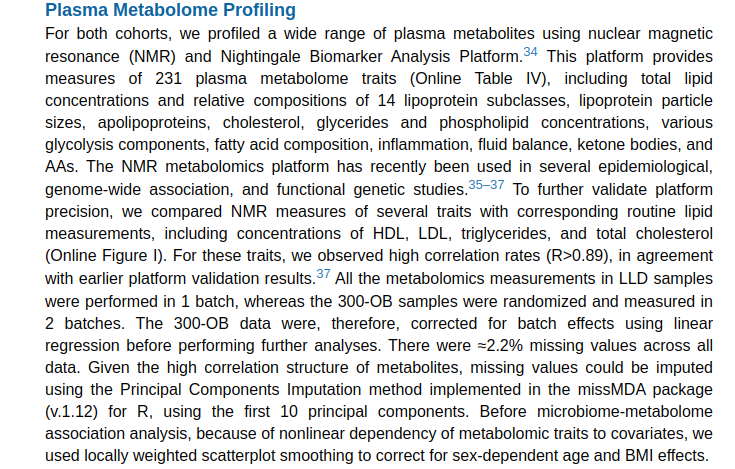

**Note**: 
* They suggest to impute missing values using Prinical Components imputation (missMDA package in R) using the first 10 pricinpal component.
* They suggest to correct for sex-dependent age ang BMI effects using locally weighted scatterplot smoothing.

*Which preprocess they did to the data?*

It seems like it's the raw NMR data. But I'm looking deeper into the article to see wether they preform normalization and which

-> It wasn't clear from the article nor from the supplementay data


In [13]:
import gzip

blood_metabolites_names_path = '/groups/umcg-lifelines/rsc01/releases/deep_nmr_data/v1/data/NMR_lipid_names.txt.gz'
with gzip.open(blood_metabolites_names_path, 'rb') as f:
    blood_metabolites_names = pd.read_csv(f, sep='\t')
blood_metabolites_names = blood_metabolites_names.set_index('Metabolite').squeeze()

In [14]:
blood_metabolites_names.head()

Metabolite
S.VLDL.C                Total cholesterol in small VLDL (mmol/l)
ApoB.ApoA1       Ratio of apolipoprotein B to apolipoprotein A-I
VLDL.C                        Total cholesterol in VLDL (mmol/l)
S.VLDL.FC                Free cholesterol in small VLDL (mmol/l)
XXL.VLDL.CE    Cholesterol esters in chylomicrons and extreme...
Name: Metabolite full name, dtype: object

In [15]:

blood_metabolites_path =  '/groups/umcg-lifelines/rsc01/releases/deep_nmr_data/v1/data/LLD_bloodlipids_nmr.txt.gz'

with gzip.open(blood_metabolites_path, 'rb') as f:
    blood_metabolites = pd.read_csv(f, sep='\t')

In [16]:
blood_metabolites = blood_metabolites.set_index('id').rename({'id':'LLDEEP_ID'})

In [17]:
blood_metabolites.head()

,XXL.VLDL.P,XXL.VLDL.L,XXL.VLDL.PL,XXL.VLDL.C,XXL.VLDL.CE,XXL.VLDL.FC,XXL.VLDL.TG,XL.VLDL.P,XL.VLDL.L,XL.VLDL.PL,...,Leu,Val,Phe,Tyr,Ace,AcAce,bOHBut,Crea,Alb,Gp
id,,,,,,,,,,,,,,,,,,,,,
LLDeep_0001,2.450000e-11,0.00528,0.000636,0.00109,0.000688,0.000397,0.00356,0.000000e+00,0.0000,0.00000,...,0.0641,0.215,0.0350,0.0524,0.0759,0.0392,0.1510,0.0574,0.0878,1.06
LLDeep_0002,1.570000e-10,0.03360,0.003910,0.00582,0.003270,0.002550,0.02390,8.120000e-10,0.0797,0.01190,...,0.0713,0.171,0.0434,0.0641,0.0502,0.0356,0.0525,0.0801,0.0901,1.22
LLDeep_0004,7.330000e-11,0.01590,0.001820,0.00360,0.002360,0.001240,0.01050,3.950000e-10,0.0396,0.00583,...,0.0755,0.184,0.0392,0.0397,0.0814,0.0482,0.0635,0.0822,0.0906,1.07
LLDeep_0005,8.570000e-11,0.01810,0.002250,0.00231,0.001010,0.001300,0.01350,4.200000e-10,0.0405,0.00519,...,0.0708,0.173,0.0338,0.0616,0.0555,0.0380,0.0711,0.0706,0.0901,1.09
LLDeep_0006,1.690000e-09,0.36000,0.044200,0.05540,0.025900,0.029500,0.26000,9.520000e-09,0.9220,0.15100,...,NaN,NaN,0.0519,0.0836,0.0615,0.1270,NaN,0.0939,0.1000,2.15


As preprocessing we will log-transform the data and then apply Standard scalling, so that it will resamble more to normal distribution. 

We still need to Impute the data! 

In [18]:
# Note zero is nan values:
blood_metabolites = blood_metabolites.replace(to_replace=0, value=np.nan).map(lambda x: np.log(x))

# Extract statistics on missing values (number on nans)
print(blood_metabolites.shape)
print(np.sum(blood_metabolites.isna()).describe)
print(np.sum(blood_metabolites.isna()).sort_values()[-30:])

(1440, 231)
<bound method NDFrame.describe of XXL.VLDL.P     91
XXL.VLDL.L     91
XXL.VLDL.PL    91
XXL.VLDL.C     91
XXL.VLDL.CE    91
               ..
AcAce           0
bOHBut          6
Crea            0
Alb             0
Gp              0
Length: 231, dtype: int64>
XXL.VLDL.FC       91
XXL.VLDL.PL_p     91
L.VLDL.CE         97
L.VLDL.TG         97
L.VLDL.P          97
L.VLDL.C          97
L.VLDL.PL         97
L.VLDL.FC         97
L.VLDL.FC_p       97
L.VLDL.L          97
L.VLDL.CE_p       97
L.VLDL.C_p        97
L.VLDL.TG_p       97
L.VLDL.PL_p       97
XL.VLDL.PL_p     234
XL.VLDL.TG       234
XL.VLDL.CE       234
XL.VLDL.L        234
XL.VLDL.P        234
XL.VLDL.C_p      234
XL.VLDL.C        234
XL.VLDL.FC       234
XL.VLDL.PL       234
XL.VLDL.TG_p     234
XL.VLDL.FC_p     234
XL.VLDL.CE_p     234
CLA.FA           289
CLA              289
DAG              291
DAG.TG           302
dtype: int64


/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Most metabolites have almost all the samples (really small number of missing values, <10% of the samples, out of ~1400 samples) But a few 30/231 are missing around 20% of the samples. 

Currently we will drop this metabolites from the anaylsis, if we would like to include them, then we shell consider missing data imputtation.

In [19]:
blood_metabolites = blood_metabolites[blood_metabolites.columns[((blood_metabolites.isna().sum() / blood_metabolites.shape[0]).sort_values()) < 0.15]]

In [20]:
blood_metabolites.to_pickle('preprocessed_data/blood_metabolites_preprocessed.pkl')

In [21]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
blood_metabolites = pd.DataFrame(standard_scaler.fit_transform(blood_metabolites), index=blood_metabolites.index, columns = blood_metabolites.columns)

In [22]:
blood_metabolites.head()

,XXL.VLDL.P,XXL.VLDL.L,XXL.VLDL.PL,XXL.VLDL.C,XXL.VLDL.CE,XXL.VLDL.FC,XXL.VLDL.TG,XL.VLDL.P,XL.VLDL.L,XL.VLDL.PL,...,DHA.FA,LA.FA,CLA.FA,FAw3.FA,FAw6.FA,PUFA.FA,MUFA.FA,SFA.FA,Glc,Lac
id,,,,,,,,,,,,,,,,,,,,,
LLDeep_0001,-0.960186,-0.975006,-0.976378,-0.968798,-0.867496,-0.894215,-0.894032,NaN,NaN,NaN,...,1.247678,1.129114,-1.061611,1.254384,0.987856,1.234878,-1.301227,0.009423,-0.243747,-1.237259
LLDeep_0002,0.667838,0.661126,0.616000,0.521485,0.463438,0.579550,0.688658,0.552067,0.544621,0.522335,...,-0.157150,0.094387,-0.101952,0.464307,-0.211673,-0.109579,0.657645,-0.754861,-0.627113,0.517766
LLDeep_0004,0.000278,-0.000370,-0.054501,0.094124,0.184975,0.008255,0.004999,-0.086775,-0.089211,0.002070,...,0.286989,-0.396168,1.029052,-0.079851,0.101057,0.071180,-0.276022,0.589804,-1.295281,-0.345631
LLDeep_0005,0.137256,0.114204,0.131466,-0.300604,-0.539691,0.045698,0.213890,-0.032370,-0.068846,-0.082718,...,-1.008610,0.585793,NaN,-1.309840,0.700350,0.424288,0.339069,-1.205283,-0.855834,-0.749634
LLDeep_0006,2.750435,2.757861,2.742441,2.526129,2.230426,2.519541,2.672553,2.734380,2.763247,2.374919,...,-1.515740,-4.416276,0.959469,-0.712045,-5.791740,-5.680774,2.289055,3.305366,1.702902,-0.401905


In [23]:
blood_metabolites.to_pickle('preprocessed_data/blood_metabolites_preprocessed_scaled.pkl')